In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import jsonlines
import mavmit.mavmitfieldnames as FN 

In [2]:
data_dir = '2021-05-24_radio_test/'

data_timestamp_s = "2021-05-24_00-10-1621807804"

packets_s = "packets_s/transmit-{}".format(data_timestamp_s) 
packets_s_sent =  "{}{}.sentpackets.jl".format(data_dir, packets_s)
packets_s_rcvd = "{}{}.receivedpackets.jl".format(data_dir, packets_s)
packets_s_all = "{}{}.allpackets.jl".format(data_dir, packets_s)

data_timestamp_s = "2021-05-24_00-10-1621807800"

packets_r = "packets_r/transmit-{}".format(data_timestamp_s)
packets_r_sent = "{}{}.sentpackets.jl".format(data_dir, packets_r)
packets_r_rcvd = "{}{}.receivedpackets.jl".format(data_dir, packets_r)
packets_r_all = "{}{}.allpackets.jl".format(data_dir, packets_r)

In [3]:
# according to test run / test data
r_MD_SRC_COMPONENT = 123
s_MD_SRC_COMPONENT = 234

In [4]:
def try_open(path_w_filename, description):
    try:
        with open(path_w_filename) as f:
            print(f"{description} is accessible")
    except IOError:
        print(f"{description} ~ {path_w_filename} is not accessible")


try_open(packets_s_sent, "packets_s_sent")
try_open(packets_s_rcvd, "packets_s_rcvd")
try_open(packets_s_all, "packets_s_all")
try_open(packets_r_sent, "packets_r_sent")
try_open(packets_r_rcvd, "packets_r_rcvd")
try_open(packets_r_all, "packets_r_all")

packets_s_sent is accessible
packets_s_rcvd is accessible
packets_s_all is accessible
packets_r_sent is accessible
packets_r_rcvd is accessible
packets_r_all is accessible


In [5]:
# to know the *complete* state (including the values fixed and rxerrors) 
# of the radio connection one has to look at the radio status packets 
# received from the radio on each side of the connection.

# anyway the radio status packets contain some values of the radio on 
# the other side.

# if the test data is about one way transmission there is no value in the 
# fixed and rxerrors values of the sending side.

# the following analysis looks at a one way transmission.

In [6]:
s_sent = pd.read_json(packets_s_sent, lines=True)
s_rcvd = pd.read_json(packets_s_rcvd, lines=True)
s_all = pd.read_json(packets_s_all, lines=True)
r_sent = pd.read_json(packets_r_sent, lines=True)
r_rcvd = pd.read_json(packets_r_rcvd, lines=True)
r_all = pd.read_json(packets_r_all, lines=True)

In [7]:
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

def conf_full(x):
    pd.set_option('display.max_rows', 7)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)

In [8]:
# to know the *complete* state (including the values fixed and rxerrors) 
# of the radio connection one has to look at the radio status packets 
# received from the radio on each side of the connection.

# anyway the radio status packets contain some values of the radio on 
# the other side.

# if the test data is about one way transmission there is no value in the 
# fixed and rxerrors values of the sending side.

# the following analysis is about at a one way transmission.

s = s_sent # missing heartbeat from r side
s = s_all # including heartbeat from r side
r = r_all # including heartbeat from s side 

In [9]:
s_head = s.iloc[0]
t_head = r.iloc[0]

In [10]:
r.drop(columns=[
    "HEADER_CREATE_TIME_US",
    "HEADER_INPUTDIR",
    "HEADER_MAVLINKDEVICE",
    "HEADER_MAVLINKBAUD",
    "HEADER_SRCSYSTEM",
    "HEADER_SRCCOMPONENT",
    "HEADER_SRCCOMPONENTTYPE",
    "HEADER_TARGETSYSTEM",
    "HEADER_TARGETCOMPONENT",
    "HEADER_HEARTBEATINTERVAL",
    "HEADER_DURATION",
    "HEADER_LOGFILE",
    "HEADER_PACKETSFILE",
    "HEADER_SENTPACKETSFILE",
    "HEADER_RECEIVEDPACKETSFILE",
    "HEADER_BOOTTIME_MS"], inplace=True)

s.drop(columns=[
    "HEADER_CREATE_TIME_US",
    "HEADER_INPUTDIR",
    "HEADER_MAVLINKDEVICE",
    "HEADER_MAVLINKBAUD",
    "HEADER_SRCSYSTEM",
    "HEADER_SRCCOMPONENT",
    "HEADER_SRCCOMPONENTTYPE",
    "HEADER_TARGETSYSTEM",
    "HEADER_TARGETCOMPONENT",
    "HEADER_HEARTBEATINTERVAL",
    "HEADER_DURATION",
    "HEADER_LOGFILE",
    "HEADER_PACKETSFILE",
    "HEADER_SENTPACKETSFILE",
    "HEADER_RECEIVEDPACKETSFILE",
    "HEADER_BOOTTIME_MS"], inplace=True)

In [11]:
# list(s.columns.values)
# list(r.columns.values)

In [12]:
# trying to calculate the relevant part of the data ...
# point is, that the short status messages are prioritized in mavmit
# therfore they arrive earlier than images that have been written to 
# send before them -> either make sure that "sync stop" status messages 
# are sent late enough or don't use them / ignore them.

In [13]:
s_syncstart_row = s[ s[FN.MSGDICT_STATUSTEXT_TEXT]=="analysis_sync_start" ]
s_syncstop_row = s[ s[FN.MSGDICT_STATUSTEXT_TEXT]=="analysis_sync_stop" ]

r_syncstart_row = r[ r[FN.MSGDICT_STATUSTEXT_TEXT]=="analysis_sync_start" ]
r_syncstop_row = r[ r[FN.MSGDICT_STATUSTEXT_TEXT]=="analysis_sync_stop" ]

In [14]:
r_syncstart_row_index = r_syncstart_row.index[0] 
r_syncstop_row_index = r_syncstop_row.index[0]

s_syncstart_row_index = s_syncstart_row.index[0] 
s_syncstop_row_index = s_syncstop_row.index[0]

In [15]:
r.drop(r.index[:r_syncstart_row_index], inplace=True)
s.drop(s.index[:s_syncstart_row_index], inplace=True)
r.reset_index(drop=True, inplace=True)
s.reset_index(drop=True, inplace=True)

In [16]:
r_syncstart_timestamp_us = r_syncstart_row[FN.MSGDICT_RECV_TIMESTAMP_US]
s_syncstart_timestamp_us = s_syncstart_row[FN.MSGDICT_SEND_TIMESTAMP_US]

print("r_syncstart_timestamp_us : %d " % r_syncstart_timestamp_us)
print("s_syncstart_timestamp_us : %d " % s_syncstart_timestamp_us)

r_syncstart_timestamp_us : 1621807810951663 
s_syncstart_timestamp_us : 1621807810774972 


In [17]:
r_s_timedelta_us = r_syncstart_timestamp_us.iat[0] - s_syncstart_timestamp_us.iat[0]

print("r_syncstart_timestamp_us - s_syncstart_timestamp_us : %d" % r_s_timedelta_us)

r_syncstart_timestamp_us - s_syncstart_timestamp_us : 176690


In [18]:
print("time difference between send and receive is %i us, \n" 
      "including local clock differences and the transmission time\n" % r_s_timedelta_us)

# ENCAPSULATED_DATA successive MD_SEND_TIMESTAMP_US at 57600 Baud
# 162180781472 3115.2
# ~ 900
# 162180781482 4025.2
# ~ 1000
# 162180781492 5120.2
# ~1200
# 162180781502 6327.2
# ~1100
# 162180781512 7452.2
# ~1000
# 162180781522 8491.2
# ~1100
# 162180781532 9521.5

print("tranmission time for a ENCAPSULATED_DATA packet at 57600 Baud is ~ 1100 us\n")

# ENCAPSULATED_DATA successive MD_RECV_TIMESTAMP_US at 57600 Baud
# 162180781297 3678.2
#   ~500
# 162180781297 4177.8
#   ~ 1800
# 162180781307 6040.8
#   ~ 600
# 162180781327 7657.0
#   ~ 600
# 162180781327 8202.8
# the MD_RECV_TIMESTAMP_US data is not added by the modem, but by the receiving sytem after 
# fetching the packet data from modem.
# the jitter probably is caused by non realtime / non deterministic processing on the receiving sytem. 


# ENCAPSULATED_DATA matching packets recv - send latency with not empty buffers at 57600 Baud
# 171272 us
# 186629 us
# ??? recheck 

print("Beware: \n" 
    "after adjusting the time delta there still may be cases where \n"
    "because of jitter and diverging clocks wrong correlations are possible \n"
    "if the matching window is long enough to match all correct packets.\n"
    "especially the varying effect of buffering is not captured when\n"
    "syncing time on a packet sent in a situation where buffers are empty.\n"
)

time difference between send and receive is 176690 us, 
including local clock differences and the transmission time

tranmission time for a ENCAPSULATED_DATA packet at 57600 Baud is ~ 1100 us

Beware: 
after adjusting the time delta there still may be cases where 
because of jitter and diverging clocks wrong correlations are possible 
if the matching window is long enough to match all correct packets.
especially the varying effect of buffering is not captured when
syncing time on a packet sent in a situation where buffers are empty.



In [19]:
r['ADJ_RECV_TIMESTAMP_US']=r['MD_RECV_TIMESTAMP_US'] - r_s_timedelta_us
r['ADJ_SEND_TIMESTAMP_US']=r['MD_SEND_TIMESTAMP_US'] - r_s_timedelta_us

In [20]:
sr_concat_adjusted_time=pd.concat([s,r])
sr_concat_adjusted_time.to_csv("sr_concat_adjusted_time.csv")
#list(sr_concat_adjusted_time.columns.values)

In [21]:
print("r MD_RECV_TIMESTAMP_US  : %d " %r.iloc[0]['MD_RECV_TIMESTAMP_US'])
# print("r MD_SEND_TIMESTAMP_US %d " % r.iloc[0]['MD_SEND_TIMESTAMP_US'])
print("r ADJ_RECV_TIMESTAMP_US : %d " % r.iloc[0]['ADJ_RECV_TIMESTAMP_US'])
# print("r ADj_SEND_TIMESTAMP_US %d " % r.iloc[0]['ADK_TEMP_TIMESTAMP_US'])

# print("s MD_RECV_TIMESTAMP_US  : %d " % s.iloc[0]['MD_RECV_TIMESTAMP_US'])
print("s MD_SEND_TIMESTAMP_US  : %d " % s.iloc[0]['MD_SEND_TIMESTAMP_US'])
# print("s ADJ_RECV_TIMESTAMP_US : %d " % s.iloc[0]['ADJ_RECV_TIMESTAMP_US'])
# print("s ADj_SEND_TIMESTAMP_US : %d " % s.iloc[0]['ADK_TEMP_TIMESTAMP_US'])

time_zero_us = s.iloc[0]['MD_SEND_TIMESTAMP_US'] 

r MD_RECV_TIMESTAMP_US  : 1621807810951663 
r ADJ_RECV_TIMESTAMP_US : 1621807810774972 
s MD_SEND_TIMESTAMP_US  : 1621807810774972 


In [22]:
# list(r.columns.values)

In [23]:
# list(s.columns.values)

In [24]:
# the analysis aims to determine and show how many and 
# which packets have been lost. the send and received packets 
# have to be matched/correlated   
#
# how to "match" sent and received packets
#
#   - matching on timestamp is tricky due to the time differences
# and correcting time for sent and received packets based on 
# one offset is not enough because the offset for later packets 
# will be different due to buffering, different packet 
# lengths ~ different transmission durations, diverging clocks,...
#
# especially the varying effect of buffering is not captured
# when syncing time on a packet sent in a situation where buffers 
# are empty
#
#   - matching on packet data would be a better (not perfect) 
# approach as the packets have changing metadata (as the sequence 
# number) that alters the packet even when uniform data (e.g. 
# monochrome picture) is sent.
# But the packet data is not available for sent packages.
# --> make an issue @ pycharm
#
#   - joining on packet type, transmitted data, seq_num, ...  
# within a time window is a feasible approach. 
#
# The matching of packets has only to be done for packets sent 
# from source to target => e.g . radio status packets can't be 
# matched.
# Later it has to be decided if all or just specific packet types 
# are d - effort for implementation vs. value of results.
#  

In [25]:
# matching of encapsulated data packets 
#
# the test data/test procedure contains/covers the edge cases
# - same packet content
# - with same seq number 

In [26]:
print("s num packets : %d" % s["MD_DATA_HEXENCODED"].count())
print("r num packets : %d" % r["MD_DATA_HEXENCODED"].count())
print("s num packets unique : %d" % s["MD_DATA_HEXENCODED"].nunique())
print("r num packets unique : %d" % r["MD_DATA_HEXENCODED"].nunique())

s num packets : 150
r num packets : 135
s num packets unique : 75
r num packets unique : 75


In [27]:
s["CORR_MISSING_IN_R"]=True

In [28]:
list(s.columns.values)

['MD_TAG_DIRECTION',
 'MD_MSG_TYPE',
 'MD_MSG_ID',
 'MD_SEQ',
 'MD_MSG_SIGNED',
 'MD_MSG_CRC',
 'MD_SRC_SYSTEM',
 'MD_SRC_COMPONENT',
 'MD_MSGBUF_HEXENCODED',
 'MD_RECV_TIMESTAMP_US',
 'MD_LINK_ID',
 'MD_SEND_TIMESTAMP_US',
 'MD_MAV_TYPE',
 'MD_MAV_AUTOPILOT',
 'MD_RADIO_STATUS_TXBUF',
 'MD_RADIO_STATUS_REMRSSI',
 'MD_RADIO_STATUS_REMNOISE',
 'MD_RADIO_STATUS_RSSI',
 'MD_RADIO_STATUS_NOISE',
 'MD_RADIO_STATUS_FIXED',
 'MD_STATUSTEXT_TEXT',
 'MD_STATUSTEXT_SEVERITY',
 'MD_PACKET_CREATE_TIMESTAMP_US',
 'MD_TIME_SINCE_BOOT_MS',
 'MD_TARGET_SYSTEM',
 'MD_TARGET_COMPONENT',
 'MD_NAMED_VALUE_NAME',
 'MD_NAMED_VALUE_INT_VALUE',
 'MD_NAMED_VALUE_FLOAT_VALUE',
 'MD_DATA_STREAM_TYPE',
 'MD_IMAGE_WIDTH',
 'MD_IMAGE_HEIGHT',
 'MD_IMAGE_QUALITY_JPG',
 'MD_BYTES_NUM',
 'MD_PACKETS_NUM',
 'MD_PACKET_PAYLOAD_BYTES',
 'MD_DATA_HEXENCODED',
 'CORR_MISSING_IN_R']

In [29]:
def match_image_packet(msg_type, msg_seq, msg_data_hex, time_center_us, window_width_us):
    upper_us = time_center_us + window_width_us
    lower_us = time_center_us - window_width_us
   
    if msg_type == "ENCAPSULATED_DATA":
        qs = f'MD_MSG_TYPE == "{msg_type}"' \
        f' and ADJ_RECV_TIMESTAMP_US < {upper_us}' \
        f' and {lower_us} < ADJ_RECV_TIMESTAMP_US' \
        f' and MD_DATA_HEXENCODED == "{msg_data_hex}"' 
        # f' and MD_SEQ == {msg_seq}' \

        result = r.query(qs)
        return len(result.index)
        
        # print (qs)
        # if result.empty:
        #    print ("- miss")
        #    print (len(result.index))
        # else:
        #    print ("+ match ")
        #    print (len(result.index))

    else:
        # print("-")
        return None

In [30]:
window_widths_us = [1000, 
                    10000, 
                    100000, 300000, 500000, 700000, 900000, 
                    1000000, 2000000, 3000000, 4000000, 
                    10000000, 
                    100000000,
                    1000000000]

for w in window_widths_us:
    res = s.apply(lambda row: match_image_packet( \
        row.MD_MSG_TYPE, \
        row.MD_SEQ, \
        row.MD_DATA_HEXENCODED, \
        row.MD_SEND_TIMESTAMP_US, \
        w), \
        axis=1)
    print("\nwindow width %d us" % w)
    print(res.value_counts())


window width 1000 us
0.0    150
dtype: int64

window width 10000 us
0.0    140
1.0     10
dtype: int64

window width 100000 us
1.0    78
0.0    72
dtype: int64

window width 300000 us
1.0    133
0.0     17
dtype: int64

window width 500000 us
1.0    135
0.0     15
dtype: int64

window width 700000 us
1.0    135
0.0     15
dtype: int64

window width 900000 us
1.0    135
0.0     15
dtype: int64

window width 1000000 us
1.0    135
0.0     15
dtype: int64

window width 2000000 us
1.0    135
0.0     15
dtype: int64

window width 3000000 us
1.0    135
0.0     15
dtype: int64

window width 4000000 us
1.0    80
2.0    56
0.0    14
dtype: int64

window width 10000000 us
1.0    80
2.0    56
0.0    14
dtype: int64

window width 100000000 us
2.0    120
1.0     30
dtype: int64

window width 1000000000 us
2.0    120
1.0     30
dtype: int64


In [31]:
print("number of ENCAPSULATED_DATA packets in s : %d" % len(s[s.MD_MSG_TYPE == "ENCAPSULATED_DATA"]))
print("number of ENCAPSULATED_DATA packets in r : %d" % len(r[r.MD_MSG_TYPE == "ENCAPSULATED_DATA"]))
print("number lost ENCAPSULATED_DATA packets    : %d" % ( len(s[s.MD_MSG_TYPE == "ENCAPSULATED_DATA"]) - len(r[r.MD_MSG_TYPE == "ENCAPSULATED_DATA"]))) 

number of ENCAPSULATED_DATA packets in s : 150
number of ENCAPSULATED_DATA packets in r : 135
number lost ENCAPSULATED_DATA packets    : 15


In [32]:
# For the used test data and varying window widths 
#
# ...
#
# window width 300000 us
# 1.00    133
# 0.00     17
# dtype: int64
#
# window width 500000 us
# 1.00    135
# 0.00     15
# dtype: int64
#
# window width 700000 us
# 1.00    135
# 0.00     15
# dtype: int64
#
# ...
#
# and 
#
# number of ENCAPSULATED_DATA packets in s : 150
# number of ENCAPSULATED_DATA packets in r : 135
# number lost ENCAPSULATED_DATA packets    : 15
#
# the window width 500000 us looks perfect 
# + no double matches 
# + no missing matches 
# but this is depending on the order of the sent images
# in the specific test.
# with another order there might not be window width 
# that provides no double matches and no missing matches 
# => this "counting" approach is to simple and doesn't use 
# knowledge about the sending order
# 
# -> go through the sent packets, for each sent packet 
#  -> find ther first matching received packet
#  -> check if packet is sent before before received (maybe give some room for diverging clocks)
#  -> check if packet is received way to late 
#  -> mark both sent and received packets as matched 


In [33]:
# side calculation
# the sample 60x40 images are about 7KiB for uncompressed formats
# the sample 60x40 images are about 4KiB for compressed formats

# calculating with 318 bytes per ENCAPSULATED_DATA packet and 253 bytes payload
# example bmp -> 7254 bytes
# --> 28,67.. packets 
#
# 29 packets of 253 bytes payload / 263 bytes efective lenth 
# are 6838 bytes
# are 54704 bits
# are 0,95s ~ 1s  at 57600 baud
# are 950000us ~ 1000000 us at 57600 baud

In [34]:
def subtract_list(first, second):
        second = set(second)
        return [item for item in first if item not in second]


def match_image_packet_better(msg_type, msg_seq, msg_data_hex, \
                              time_center_us, width_before_us, width_after_us, \
                              df_r, df_r_indices_matched, \
                              df_r_indices_matched_match_ids, \
                              match_id):
    upper_us = time_center_us + width_after_us
    lower_us = time_center_us - width_before_us
   
    if msg_type == "ENCAPSULATED_DATA":
        qs = f'MD_MSG_TYPE == "{msg_type}"' \
        f' and ADJ_RECV_TIMESTAMP_US < {upper_us}' \
        f' and {lower_us} < ADJ_RECV_TIMESTAMP_US' \
        f' and MD_DATA_HEXENCODED == "{msg_data_hex}"' 
        # f' and MD_SEQ == {msg_seq}' \

        #print("----")
        result = df_r.query(qs)
        if not result.empty:
            result_indices = result.index.values
            result_indices_wo_matched = subtract_list( \
                    result_indices,
                    df_r_indices_matched )
            
            if len(result_indices_wo_matched) > 0:
                first_result = result_indices_wo_matched[0]
                df_r_indices_matched.append(first_result)

                match_id[0] = match_id[0] + 1 
                df_r_indices_matched_match_ids.append(match_id[0])
                return match_id[0]
            
            else:
                return 0
        return 0
 
    else:
        return 0

In [35]:
def match_images(width_before_us, width_after_us):
    s["PACKET_MATCHED"] = False
    s["PACKET_MATCHED_S"] = False
    s["PACKET_MATCHED_S_IDX"] = 0
    r["PACKET_MATCHED"] = False
    r["PACKET_MATCHED_R"] = False
    r["PACKET_MATCHED_R_IDX"] = 0

    r_indices_matched = []
    indices_matched_match_ids = []
    _match_id = [0]
    
    s_res = s.apply(lambda row: match_image_packet_better( \
            row.MD_MSG_TYPE, \
            row.MD_SEQ, \
            row.MD_DATA_HEXENCODED, \
            row.MD_SEND_TIMESTAMP_US, \
            width_before_us, \
            width_after_us, \
            r, \
            r_indices_matched, \
            indices_matched_match_ids, \
            _match_id), \
        axis=1)
    
    s["PACKET_MATCHED_S_IDX"] = s_res
    s["PACKET_MATCHED_S"] = s["PACKET_MATCHED_S_IDX"] > 0
    s["PACKET_MATCHED"] = s["PACKET_MATCHED_S"]

    # print("indices_matched :           %d" % len(r_indices_matched))
    # print("indices_matched_match_ids : %d" % len(indices_matched_match_ids))
    
    for idx, val in enumerate(r_indices_matched):
      r.at[val, "PACKET_MATCHED"] = True  
      r.at[val, "PACKET_MATCHED_R"] = True  
      r.at[val, "PACKET_MATCHED_R_IDX"] = indices_matched_match_ids[idx]  
        
    return r_indices_matched, indices_matched_match_ids

In [36]:
widths_before_us = [1000, 10000, 100000]
widths_after_us = [100000, 200000, 400000, 600000, 800000, 1000000, 1200000, 1400000]
widths_before_us = [1000]
widths_after_us = [500000]

for width_before_us in widths_before_us:
    print("-----------------------\n")
    
    for width_after_us in widths_after_us:

        match_images(width_before_us, width_after_us)
        print("width_before_us:", width_before_us)
        print("width_after_us: ", width_after_us)
        print("R PACKET_MATCHED:", r["PACKET_MATCHED"].sum())
        print("S PACKET_MATCHED:", s["PACKET_MATCHED"].sum())
        print()

-----------------------

width_before_us: 1000
width_after_us:  500000
R PACKET_MATCHED: 116
S PACKET_MATCHED: 116



In [37]:
r["TS"] = r["ADJ_RECV_TIMESTAMP_US"].combine_first(r["ADJ_SEND_TIMESTAMP_US"])
s["TS"] = s["MD_SEND_TIMESTAMP_US"] # + s["MD_RECV_TIMESTAMP_US"] 

sr = pd.concat([s,r])
sr.sort_values(by=['TS'], inplace=True, ascending=True)

sr.to_csv("sr_matched.csv")
# r.to_csv("r_matched.csv")
# s.to_csv("s_matched.csv")
# list(sr.columns.values)

In [38]:

sr=sr[sr.TS < 1621807831616389.8] # manual tweaking by looking at the data, drop tail

In [39]:
# radio send side id 51.0, comp 68.0
# radio recv side id 51.0, comp 68.0

In [40]:
def encdata_handshake(row):
    if  row["MD_MSG_TYPE"] == "DATA_TRANSMISSION_HANDSHAKE" \
    and row["MD_TAG_DIRECTION"] == "MD_TAG_DIRECTION_SEND" :
        return 145
    else:
        return None
sr["encdata_handshake"] = sr.apply(encdata_handshake, axis=1)    

def encdata_hit(row):
    if  row["MD_MSG_TYPE"] == "ENCAPSULATED_DATA" \
    and row["MD_TAG_DIRECTION"] == "MD_TAG_DIRECTION_SEND" :
        if row["PACKET_MATCHED"]:
            return 140
        else:
            None
    else:
        return None
sr["encdata_hit"] = sr.apply(encdata_hit, axis=1)    

def encdata_miss(row):
    if  row["MD_MSG_TYPE"] == "ENCAPSULATED_DATA" \
    and row["MD_TAG_DIRECTION"] == "MD_TAG_DIRECTION_SEND" :
        if row["PACKET_MATCHED"]:
            None
        else:
            return 135
    else:
        return None
sr["encdata_miss"] = sr.apply(encdata_miss, axis=1)    

def encdata_baddata(row):
    if row["MD_MSG_TYPE"] == "BAD_DATA" \
    and row["MD_TAG_DIRECTION"]=="MD_TAG_DIRECTION_RECV" :
        return 130
    else:
        return None
sr["encdata_baddata"] = sr.apply(encdata_baddata, axis=1)    


def plot_encdata(sp):
    sp.plot(
        sr.TS,
        sr["encdata_baddata"],
        marker="X",
        linestyle='none',
        color='red',
        label="bad data"
        )

    sp.plot(
        sr.TS,
        sr["encdata_handshake"],
        marker="o",
        linestyle='none',
        color='green',
        label="handshake"
        )

    sp.plot(
        sr.TS,
        sr["encdata_hit"],
        marker="x",
        linestyle='none',
        color='green',
        label="encdata hit"
        )

    sp.plot(
        sr.TS,
        sr["encdata_miss"],
        marker="x",
        linestyle='none',
        color='grey',
        label="encdata miss"
        )

In [41]:
def hb_r_send(row):
    if  row["MD_MSG_TYPE"] == "HEARTBEAT" \
    and row["MD_TAG_DIRECTION"]=="MD_TAG_DIRECTION_SEND" \
    and row["MD_SRC_SYSTEM"] == r_MD_SRC_COMPONENT :
        return 115
    else:
        return None
sr["hb_r_send"] = sr.apply(hb_r_send, axis=1)    

def hb_s_recv(row):
    if  row["MD_MSG_TYPE"] == "HEARTBEAT" \
    and row["MD_TAG_DIRECTION"]=="MD_TAG_DIRECTION_RECV" \
    and row["MD_SRC_SYSTEM"] == s_MD_SRC_COMPONENT :
        return 116
    else:
        return None
sr["hb_s_recv"] = sr.apply(hb_s_recv, axis=1)   


def hb_s_send(row):
    if  row["MD_MSG_TYPE"] == "HEARTBEAT" \
    and row["MD_TAG_DIRECTION"]=="MD_TAG_DIRECTION_SEND" \
    and row["MD_SRC_SYSTEM"] == s_MD_SRC_COMPONENT :
        return 110
    else:
        return None
sr["hb_s_send"] = sr.apply(hb_s_send, axis=1)    

def hb_r_recv(row):# no val
    if  row["MD_MSG_TYPE"] == "HEARTBEAT" \
    and row["MD_TAG_DIRECTION"]=="MD_TAG_DIRECTION_RECV" :
        return 111
    else:
        return None
sr["hb_r_recv"] = sr.apply(hb_r_recv, axis=1)    


def plot_hb(sp):
    sp.plot(
        sr.TS,
        sr["hb_r_send"],
        marker=".",
        linestyle='none',
        label="heartbeat receiver received"
        )

    sp.plot(
        sr.TS,
        sr["hb_s_send"],
        marker=".",
        linestyle='none',
        label="heartbeat sender sent"
        )

    sp.plot(
        sr.TS,
        sr["hb_r_recv"],
        marker=".",
        linestyle='none',
        label="heartbeat receiver received"
        )

    sp.plot(
        sr.TS,
        sr["hb_s_recv"],
        marker=".",
        linestyle='none',
        label="heartbeat sender received"
        )

In [42]:
def plot_radio(sp):
    sp.plot(
        sr.TS,
        sr["MD_RADIO_STATUS_TXBUF"],
        marker="+",
        linestyle='none',
        label="RADIO_STATUS_TXBUF"
        )

    sp.plot(
        sr.TS,
        sr["MD_RADIO_STATUS_FIXED"],
        marker="+",
        linestyle='none',
        label="RADIO_STATUS_FIXED"
        )

    sp.plot(
        sr.TS,
        sr["MD_RADIO_STATUS_RSSI"],
        marker="+",
        linestyle='none',
        label="RADIO_STATUS_RSSI"
        )

    sp.plot(
        sr.TS,
        sr["MD_RADIO_STATUS_REMRSSI"],
        marker="+",
        linestyle='none',
        label="RADIO_STATUS_REMRSSI"
        )

    sp.plot(
        sr.TS,
        sr["MD_RADIO_STATUS_NOISE"],
        marker="+",
        linestyle='none',
        label="RADIO_STATUS_NOISE"
        )

    sp.plot(
        sr.TS,
        sr["MD_RADIO_STATUS_REMNOISE"],
        marker="+",
        linestyle='none',
        label="RADIO_STATUS_REMNOISE"
        )

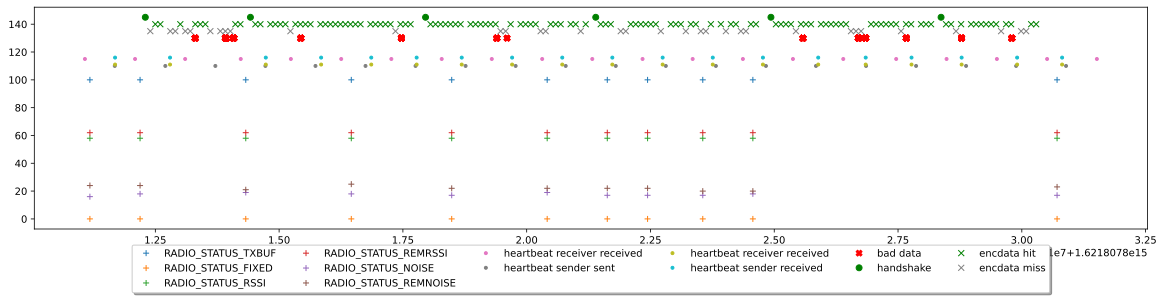

In [43]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

fig = plt.figure(figsize=(20, 10))
subplot1 = fig.add_subplot(2,1,1)

plot_radio(subplot1)
plot_hb(subplot1)
plot_encdata(subplot1)


box = subplot1.get_position()
subplot1.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

subplot1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=6)